In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr

## Read the dataset and perform necessary data tidying

In [2]:
# Read the data
df = pd.read_excel("soil_data.xlsx")

# Convert SOC from g/kg to %
df['SOC'] = df['SOC'] / 10

# Select features
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP']

# Remove rows that contain NaN values in the selected feature columns
df = df.dropna(subset=features)

# Select only the feature variables needed for correlation calculation
df_features = df[features]

df.head()


,no,year,date,treatmentnumber,treatment,plot,depthnumber,depth,SOC,sand,...,clay,BD,FC,FC_33,PWP,Ka,EC,SAR,WR,pH
3,4,2021,2021-03-27,0,rainfed,2,1,0-20,1.912,58.430458,...,10.878011,1.148851,0.3126,0.2677,0.1680,28.257534,0.131567,0.267706,7.25,7.61
4,5,2021,2021-03-27,0,rainfed,2,2,20-40,1.897,58.326958,...,11.469644,1.388839,0.3086,0.2763,0.1954,7.093154,0.126533,0.139694,20.25,7.58
5,6,2021,2021-03-27,0,rainfed,2,3,40-60,1.699,57.414452,...,10.646388,1.438689,0.3086,0.2693,0.1580,1.123574,0.120433,0.294239,24.75,7.57
9,10,2021,2021-03-27,0,rainfed,4,1,0-20,1.655,59.471977,...,10.421492,1.348851,0.2981,0.2302,0.1640,5.548042,0.124367,0.142143,19.25,7.61
10,11,2021,2021-03-27,0,rainfed,4,2,20-40,1.631,59.312145,...,10.363888,1.588839,0.3496,0.2945,0.1622,2.006630,0.124867,0.263550,17.50,7.64


## Calculate the Pearson correlation and p-value, marking significant differences with *

In [3]:
# Select feature variables
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP']  
# If calculating for the 0-60 cm depth, include 'depthnumber' and 'treatmentnumber'

# Calculate the Pearson correlation matrix and the p-value matrix
correlation_matrix = pd.DataFrame(index=features, columns=features)
p_value_matrix = pd.DataFrame(index=features, columns=features)

for feature1 in features:
    for feature2 in features:
        if feature1 == feature2:
            correlation_matrix.loc[feature1, feature2] = 1.0
            p_value_matrix.loc[feature1, feature2] = 0.0
        else:
            corr, p_value = pearsonr(df[feature1], df[feature2])
            correlation_matrix.loc[feature1, feature2] = corr
            p_value_matrix.loc[feature1, feature2] = p_value

# Print the correlation matrix
print("Pearson correlation coefficients:")
print(correlation_matrix)

# Print the p-value matrix
print("\nP-values for the Pearson correlation coefficients:")
print(p_value_matrix)

# Mark pairs of features with significant correlations (p-value < 0.05)
print("\nSignificant correlations (p-value < 0.05):")
significant_correlation_matrix = correlation_matrix.copy()

for feature1 in features:
    for feature2 in features:
        if feature1 != feature2 and p_value_matrix.loc[feature1, feature2] < 0.05:
            significant_correlation_matrix.loc[feature1, feature2] = f"{correlation_matrix.loc[feature1, feature2]:.3f}*"

print(significant_correlation_matrix)

# Save the significant correlation matrix to a CSV file
significant_correlation_matrix.to_csv('significant_correlation_matrix.csv', index=False)


Pearson correlation coefficients:
            SOC      sand      silt      clay        BD        FC     FC_33  \
SOC         1.0 -0.311044  0.189334  0.563066 -0.192017  0.321034  0.346155   
sand  -0.311044       1.0 -0.972643 -0.715055 -0.173645 -0.673239 -0.687953   
silt   0.189334 -0.972643       1.0  0.533096  0.151857  0.622956  0.627195   
clay   0.563066 -0.715055  0.533096       1.0  0.175434  0.577293  0.618123   
BD    -0.192017 -0.173645  0.151857  0.175434       1.0  0.390704  0.369912   
FC     0.321034 -0.673239  0.622956  0.577293  0.390704       1.0  0.967851   
FC_33  0.346155 -0.687953  0.627195  0.618123  0.369912  0.967851       1.0   
PWP    0.465519 -0.360476  0.271607  0.495512   0.11278  0.560693  0.545896   

            PWP  
SOC    0.465519  
sand  -0.360476  
silt   0.271607  
clay   0.495512  
BD      0.11278  
FC     0.560693  
FC_33  0.545896  
PWP         1.0  

P-values for the Pearson correlation coefficients:
            SOC      sand      silt     

## Test different Pedo-tansfer models on FC, PWP, and together calculation

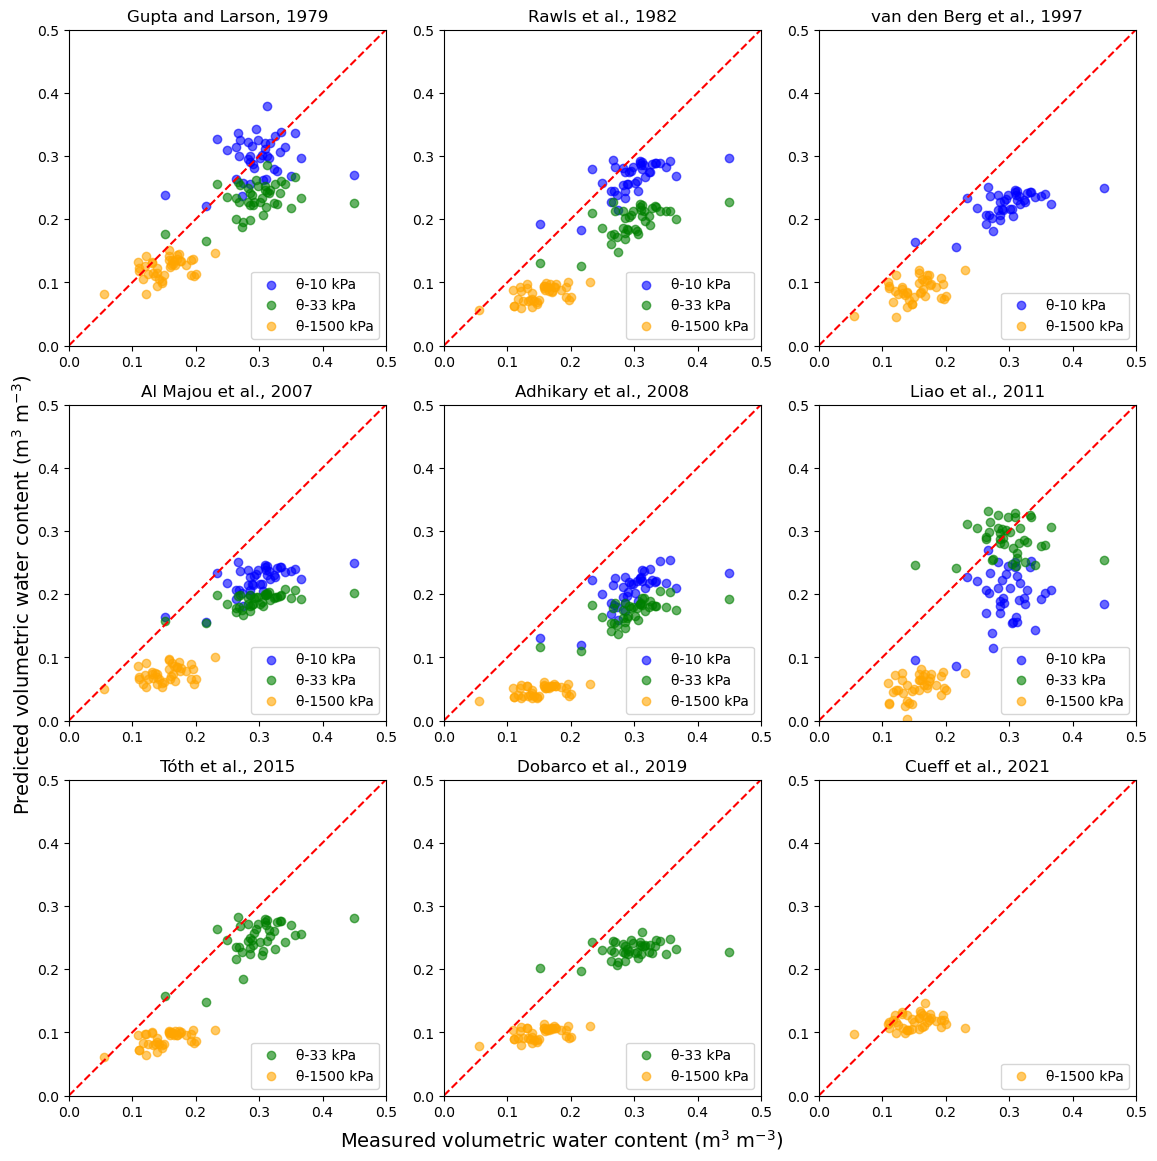

In [4]:
# Read the data
df = pd.read_excel("soil_data.xlsx")

# Convert SOC from g/kg to %
df['SOC'] = df['SOC'] / 10

# Select features
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP']

# Remove rows that contain NaN values in the selected feature columns
df = df.dropna(subset=features)

# Select only the feature variables needed for correlation calculation
df_features = df[features]

# Calculate FC_10 predictions for each model
df['fc10_Gupta1979'] = 0.005018*df['sand'] + 0.008548*df['silt'] + 0.008833*df['clay'] + 0.00288051 *df['SOC'] - 0.2423*df['BD']
df['pwp_Rawls1982'] = 0.0260 + 0.0050 * df['clay'] + 0.009164 * df['SOC']
df['fc33_Rawls1982'] = 0.2391 - 0.0019 * df['sand'] + 0.01218 * df['SOC'] + 0.72 * df['pwp_Rawls1982']
df['fc10_Rawls1982'] = 0.0619 - 0.0002 * df['sand'] - 0.003886 * df['SOC'] + 1.34 * df['fc33_Rawls1982'] - 0.51 * df['pwp_Rawls1982']
df['fc10_Vandenberg1997'] = 0.1088 + 0.00347 * df['clay'] + 0.00211 * df['silt'] + 0.01756 * df['SOC']
df['fc10_Almajou2007'] = 0.1088 + 0.00347 * df['clay'] + 0.00211 * df['silt'] + 0.01756 * df['SOC']
df['fc10_Adhikary2008'] = 0.6250 - 0.0058 * df['sand'] - 0.0021 * df['silt']
df['fc10_Liao2011'] = (
    -2.44344 + 
    2.128 * df['BD'] + 
    0.275 * np.log(df['sand']) + 
    0.068 * np.log(df['SOC']) + 
    0.00013 * df['silt']**2 - 
    0.808 * df['BD']**2 - 
    0.00003364  * df['sand'] * df['SOC'] + 
    0.00008 * (df['BD']**2) * (df['clay']**2)
)



# Calculate FC_33 predictions for each model
df['fc33_Gupta1979'] = 0.003075*df['sand'] + 0.005886*df['silt'] + 0.008039*df['clay'] + 0.00128074 *df['SOC'] - 0.1434*df['BD']
df['pwp_Rawls1982'] = 0.0260 + 0.0050 * df['clay'] + 0.009164 * df['SOC']
df['fc33_Rawls1982'] = 0.2391 - 0.0019 * df['sand'] + 0.01218 * df['SOC'] + 0.72 * df['pwp_Rawls1982']
df['fc33_Almajou2007'] = 0.1301 + 0.0038 * df['clay'] + 0.0012 *df['silt'] + 0.0010 * df['SOC'] - 0.0084  * df['BD'] 
df['fc33_Adhikary2008'] = 0.5637 - 0.0051 * df['sand'] - 0.0027 * df['silt'] 
df['fc33_Liao2011'] = (
    -1.88394 + 
    3.158 * df['BD'] +  
    0.042 * np.log(df['SOC']) - 
    1.139 * df['BD']**2 - 
    0.000058 * df['sand'] * df['SOC'] + 
    0.000058 * df['silt'] * df['SOC'] 
)
df['fc33_Toth2015'] = ( 0.2449 - 0.1887 * (1/(df['SOC']+1)) + 0.004527 * df['clay'] + 
                       0.001535 * df['silt'] + 0.001442 * df['silt'] * (1/(df['SOC']+1)) 
                       - 0.00005110 * df['silt'] * df['clay'] + 0.0008676 * df['clay'] * (1/(df['SOC']+1))
                      )
df['fc33_Dobarco2019'] = 0.394 + 0.00229 * df['clay'] - 0.00124 * df['sand'] - 0.0758 * df['BD']




# Calculate PWP predictions for each model
df['pwp_Gupta1979'] = -0.000059 *df['sand'] + 0.001142 *df['silt'] + 0.005766*df['clay'] + 0.00129234 *df['SOC'] + 0.02671*df['BD']
df['pwp_Rawls1982'] = 0.0260 + 0.0050 * df['clay'] + 0.009164 * df['SOC']
df['pwp_Vandenberg1997'] = 0.00334 * df['clay'] * df['BD'] + 0.00104 * df['silt'] * df['BD']
df['pwp_Almajou2007'] = -0.0786 + 0.0045 * df['clay'] + 0.0003 * df['silt'] + 0.0004 * df['SOC'] + 0.0710 * df['BD']
df['pwp_Adhikary2008'] = 0.0071 + 0.0044  * df['clay']
df['pwp_Liao2011'] = (
    0.159075 + 
    0.025 * np.log(df['SOC']) -
    0.00012 * df['silt']**2 -
    0.092 * df['BD']**2 - 
    0.000085 * df['sand'] * df['silt'] + 
    0.0000174 * df['silt'] * df['SOC'] +
    0.008 * df['silt'] * df['BD'] + 
    0.00069606 * df['BD'] * df['SOC']
)
df['pwp_Toth2015'] = ( 0.09878 + 0.002127 * df['clay'] - 0.0008366 * df['silt'] - 0.07670 *(1/(df['SOC']+1)) + 
                      0.00003853 * df['silt'] * df['clay'] + 0.002330 * df['clay'] * (1/(df['SOC']+1)) + 
                      0.0009498 * df['silt'] * (1/(df['SOC']+1))
                      )
df['pwp_Dobarco2019'] = 0.074 + 0.00412 * df['clay']  - 0.000241 * df['sand'] + 0.00128 * df['SOC']
df['pwp_Cueff2021'] = 0.145 + 0.00256 * df['clay'] - 0.0856 * df['BD'] + 0.007 * df['pH'] + 0.000624 * df['silt']


# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Define models and their titles
models = [
    ('fc10_Gupta1979', 'fc33_Gupta1979', 'pwp_Gupta1979', 'Gupta and Larson, 1979'),
    ('fc10_Rawls1982', 'fc33_Rawls1982', 'pwp_Rawls1982', 'Rawls et al., 1982'),
    ('fc10_Vandenberg1997', None, 'pwp_Vandenberg1997', 'van den Berg et al., 1997'),
    ('fc10_Almajou2007', 'fc33_Almajou2007', 'pwp_Almajou2007', 'Al Majou et al., 2007'),
    ('fc10_Adhikary2008', 'fc33_Adhikary2008', 'pwp_Adhikary2008', 'Adhikary et al., 2008'),
    ('fc10_Liao2011', 'fc33_Liao2011', 'pwp_Liao2011', 'Liao et al., 2011'),
    (None, 'fc33_Toth2015', 'pwp_Toth2015', 'Tóth et al., 2015'),
    (None, 'fc33_Dobarco2019', 'pwp_Dobarco2019', 'Dobarco et al., 2019'),
    (None, None, 'pwp_Cueff2021', 'Cueff et al., 2021')
]

# Define color
colors = {
    'FC10': 'blue',  # color for FC10
    'FC33': 'green',  # color for FC33
    'PWP': 'orange'  # color for PWP
}

# Plot each model
for ax, (fc10_model, fc33_model, pwp_model, title) in zip(axs.flatten(), models):
    # Plot PWP scatter (orange)

    # Plot FC10 scatter (blue)
    if fc10_model:
        ax.scatter(df['FC'], df[fc10_model], color=colors['FC10'], alpha=0.6, label='θ-10 kPa')

    # Plot FC33 scatter (green) if applicable
    if fc33_model:
        ax.scatter(df['FC'], df[fc33_model], color=colors['FC33'], alpha=0.6, label='θ-33 kPa')
        
    if pwp_model:
        ax.scatter(df['PWP'], df[pwp_model], color=colors['PWP'], alpha=0.6, label='θ-1500 kPa')

    # Plot ideal diagonal line
    ax.plot([0, 1], [0, 1], 'r--')  # 对角线
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 0.5)
    ax.set_title(title)
    ax.legend(loc='lower right')

# Add overall x and y labels
fig.text(0.5, 0.04, 'Measured volumetric water content (m$^3$ m$^{-3}$)', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted volumetric water content (m$^3$ m$^{-3}$)', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave space for x and y labels
plt.savefig("predicted_vs_measured_water_content_colored.png")  # Save the plot
plt.show()



## Estimate the model and export the results

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the Applicability Index (AI)
def applicability_index(pred, actual):
    return (np.sum(~np.isnan(pred)) / len(actual)) * 100

# Calculate the Mean Error (ME)
def mean_error(pred, actual):
    return np.nanmean(pred - actual)

# Calculate the Standard Deviation of Error (SDE)
def std_error(pred, actual):
    return np.nanstd(pred - actual)

# Calculate the Root Mean Square Error (RMSE)
def rmse(pred, actual):
    return np.sqrt(mean_squared_error(actual, pred))

# Initialize the results list
results = []

# Define the models and their titles
models = [
    ('fc10_Gupta1979', 'fc33_Gupta1979', 'pwp_Gupta1979', 'Gupta and Larson, 1979'),
    ('fc10_Rawls1982', 'fc33_Rawls1982', 'pwp_Rawls1982', 'Rawls et al., 1982'),
    ('fc10_Vandenberg1997', None, 'pwp_Vandenberg1997', 'van den Berg et al., 1997'),
    ('fc10_Almajou2007', 'fc33_Almajou2007', 'pwp_Almajou2007', 'Al Majou et al., 2007'),
    ('fc10_Adhikary2008', 'fc33_Adhikary2008', 'pwp_Adhikary2008', 'Adhikary et al., 2008'),
    ('fc10_Liao2011', 'fc33_Liao2011', 'pwp_Liao2011', 'Liao et al., 2011'),
    (None, 'fc33_Toth2015', 'pwp_Toth2015', 'Tóth et al., 2015'),
    (None, 'fc33_Dobarco2019', 'pwp_Dobarco2019', 'Dobarco et al., 2019'),
    (None, None, 'pwp_Cueff2021', 'Cueff et al., 2021')
]

# make sure df contains necessry columns
try:
    # make sure PWP and FC columns existd
    assert 'PWP' in df.columns and 'FC' in df.columns
except NameError:
    raise ValueError("DataFrame 'df' is not defined.")
except AssertionError:
    raise ValueError("'PWP' or 'FC' columns are missing from the DataFrame.")

# Calculate metrics for each model and store them in the results list
for fc10_model, fc33_model, pwp_model, title in models:
    
         # Calculate FC10-related metrics
    if fc10_model and fc10_model in df.columns:
        pred_fc10 = df[fc10_model]
        actual_fc = df['FC']
        ai_fc10 = applicability_index(pred_fc10, actual_fc)
        me_fc10 = mean_error(pred_fc10, actual_fc)
        sde_fc10 = std_error(pred_fc10, actual_fc)
        rmse_fc10 = rmse(pred_fc10, actual_fc)
        results.append([title, 'FC10', ai_fc10, me_fc10, sde_fc10, rmse_fc10])
        
        
    # Calculate FC33-related metrics
    if fc33_model and fc33_model in df.columns:
        pred_fc33 = df[fc33_model]
        ai_fc33 = applicability_index(pred_fc33, actual_fc)
        me_fc33 = mean_error(pred_fc33, actual_fc)
        sde_fc33 = std_error(pred_fc33, actual_fc)
        rmse_fc33 = rmse(pred_fc33, actual_fc)
        results.append([title, 'FC33', ai_fc33, me_fc33, sde_fc33, rmse_fc33])

        
    # Calculate PWP-related metrics
    if pwp_model and pwp_model in df.columns:
        pred_pwp = df[pwp_model]
        actual_pwp = df['PWP']
        ai_pwp = applicability_index(pred_pwp, actual_pwp)
        me_pwp = mean_error(pred_pwp, actual_pwp)
        sde_pwp = std_error(pred_pwp, actual_pwp)
        rmse_pwp = rmse(pred_pwp, actual_pwp)
        results.append([title, 'PWP', ai_pwp, me_pwp, sde_pwp, rmse_pwp])
    


# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Type', 'Applicability Index (%)', 'Mean Error (m3/m3)', 'Standard Deviation of Error (m3/m3)', 'RMSE (m3/m3)'])



# Save the results to a CSV file
results_df.to_csv('model_performance_metrics.csv', index=False)

print("Results saved to 'model_performance_metrics.csv'")


Results saved to 'model_performance_metrics.csv'


### predict water retneiton curves by mean measured values

#### Rawls and Brakensiek (1989)

            ψ (cm)        pF  θ (cm³/cm³)
0        -0.100000 -1.000000     0.460294
1        -0.109716 -0.959732     0.460294
2        -0.120375 -0.919463     0.460294
3        -0.132070 -0.879195     0.460294
4        -0.144902 -0.838926     0.460294
..             ...       ...          ...
145  -69012.248029  4.838926     0.056690
146  -75717.214883  4.879195     0.056690
147  -83073.610749  4.919463     0.056690
148  -91144.725985  4.959732     0.056690
149 -100000.000000  5.000000     0.056690

[150 rows x 3 columns]


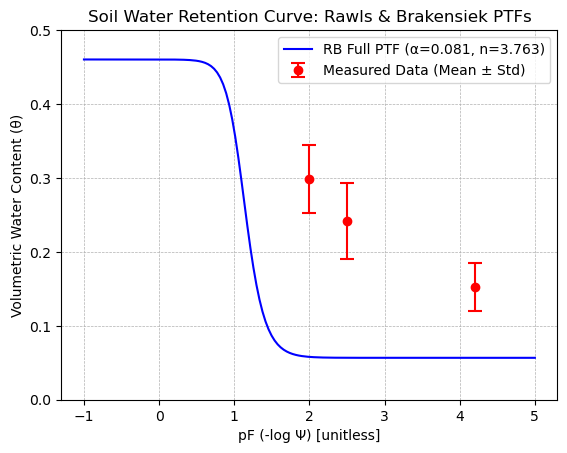

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "soil_data.xlsx"  # Ensure correct file path
df = pd.read_excel(file_path)

# Convert SOC from g/kg to % and compute OC (Organic Carbon)
df['SOC'] = df['SOC'] / 10


# Select relevant columns and remove missing values
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP', 'pH', 'SAR']
df = df.dropna(subset=features)  # Remove rows with missing values

# Compute mean values for soil properties
clay_mean = df["clay"].mean()
sand_mean = df["sand"].mean()
silt_mean = df["silt"].mean()
BD_mean = df["BD"].mean()



# Define the range of matric potential (Ψ)
psi_values = np.logspace(-1, 5, 150) * -1  # Negative values for suction
pF_values = np.log10(np.abs(psi_values))   # Convert suction to pF
# Define Rawls & Brakensiek (1985) equations from the image


# --- van Genuchten equation ---
def van_genuchten(h, theta_r, theta_s, alpha, n):
    m = 1 - 1/n
    return theta_r + (theta_s - theta_r) / ((1 + (alpha * abs(h))**n) ** m)



def rb1985_parameters(sand, clay, BD):
    # Convert texture to fraction if given in %

    phi = 1 - BD / 2.65  # Porosity

    # Saturated water content (θs)
    theta_s = phi

    # Bubbling pressure head (hb)
    hb = np.exp(
        5.3396738 + 0.1845038 * clay - 2.483945 * phi
        - 0.00213853 * clay**2 - 0.04356349 * sand * phi
        - 0.61745089 * clay * phi + 0.00143598 * sand**2 * phi**2
        - 0.00855375 * clay**2 * phi ** 2 - 0.00001282 * sand**2 * clay
        + 0.00895359 * clay**2 * phi - 0.00072472 * sand** 2 * phi
        + 0.0000054 * clay**2 * sand + 0.5002806 * clay * phi**2
    )

    a = 1 / hb  # van Genuchten α

    # n parameter
    n = 1 + np.exp(
        -0.7842831 + 0.0177544 * sand - 1.062498 * phi
        - 0.00005304 * sand**2 - 0.00273493 * clay
        + 1.11134946 * phi**2 + 0.03088295 * sand * phi
        + 0.00026587 * sand**2 * phi**2 - 0.00610522 * clay**2 * phi**2
        - 0.00000235 * sand**2 * clay + 0.00798746 * clay**2 * phi
        - 0.0067449 * clay * phi**2
    )

    # Residual water content (θr)
    theta_r = (
        -0.0182482 + 0.00087269 * sand + 0.00513488 * clay
        + 0.02939286 * phi - 0.00015395 * clay**2
        - 0.0010827 * sand * phi - 0.00018233 * clay**2 * phi**2
        + 0.00030703 * clay**2 * phi - 0.0023584 * clay * phi**2
    )

    return theta_r, theta_s, a, n

# Compute mean values
theta_r_rb2, theta_s_rb2, alpha_rb2, n_rb2 = rb1985_parameters(sand_mean, clay_mean, BD_mean)

# Compute θ(ψ) using new RB-1985 full equation
theta_rb2 = van_genuchten(psi_values, theta_r_rb2, theta_s_rb2, alpha_rb2, n_rb2)

theta_rb2

# teansfer θ(ψ) as DataFrame
theta_df = pd.DataFrame({
    "ψ (cm)": psi_values,
    "pF": pF_values,
    "θ (cm³/cm³)": theta_rb2
})

print(theta_df)


plt.plot(pF_values, theta_rb2, label=f"RB Full PTF (α={alpha_rb2:.3f}, n={n_rb2:.3f})", linestyle="solid", color="blue")

# --- Prepare measured data (means and std devs) ---
pF_measured = [2.0, 2.5, 4.2]  # pF for FC, FC_33, and PWP
theta_measured = [df["FC"].mean(), df["FC_33"].mean(), df["PWP"].mean()]
theta_std = [df["FC"].std(), df["FC_33"].std(), df["PWP"].std()]


# Overlay measured data points
plt.errorbar(pF_measured, theta_measured, yerr=theta_std, fmt='o', color="red", label="Measured Data (Mean ± Std)", capsize=5, capthick=1.5)

# Plot settings
plt.ylim(0, 0.5)
plt.xlabel("pF (-log Ψ) [unitless]")
plt.ylabel("Volumetric Water Content (θ)")
plt.title("Soil Water Retention Curve: Rawls & Brakensiek PTFs")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


#### Weynants et al. (2009)

0.41425370626043934 0.025852622231234315 1.234957925661114 0
            ψ (cm)        pF  θ (cm³/cm³)
0        -0.100000 -1.000000     0.414203
1        -0.109716 -0.959732     0.414197
2        -0.120375 -0.919463     0.414191
3        -0.132070 -0.879195     0.414183
4        -0.144902 -0.838926     0.414174
..             ...       ...          ...
145  -69012.248029  4.838926     0.071336
146  -75717.214883  4.879195     0.069799
147  -83073.610749  4.919463     0.068295
148  -91144.725985  4.959732     0.066823
149 -100000.000000  5.000000     0.065383

[150 rows x 3 columns]


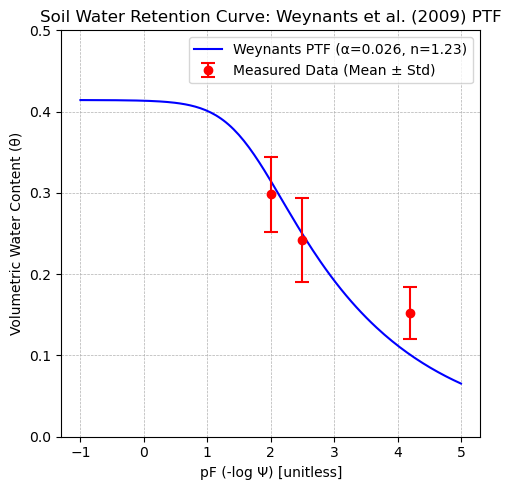

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "soil_data.xlsx"  # Ensure correct file path
df = pd.read_excel(file_path)

# Convert SOC from g/kg to % and compute OC (Organic Carbon)
df['SOC'] = df['SOC'] / 10

# Calculate additional variables
df['ESP'] = (100 * df['SAR']) / (1 + 0.0147 * df['SAR'])  # Empirical ESP formula
df['CEC'] = 25.219 + 0.132 * df['clay'] + 2.167e-2 * df['silt'] - 0.054 * df['sand'] - 2.2445 * df['pH'] + 0.865 * df['SOC']  # Khaledian et al., 2017


# Select relevant columns and remove missing values
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP', 'pH', 'SAR']
df = df.dropna(subset=features)  # Remove rows with missing values

# Compute mean values for soil properties
clay_mean = df["clay"].mean()
sand_mean = df["sand"].mean()
silt_mean = df["silt"].mean()
BD_mean = df["BD"].mean()
SOC_mean = df["SOC"].mean()

# Define the range of matric potential (Ψ)
psi_values = np.logspace(-1, 5, 150) * -1  # Negative values for suction
pF_values = np.log10(np.abs(psi_values))   # Convert suction to pF
# Define Rawls & Brakensiek (1985) equations from the image



# --- van Genuchten equation ---
def van_genuchten(h, theta_r, theta_s, alpha, n):
    m = 1 - 1/n
    return theta_r + (theta_s - theta_r) / ((1 + (-alpha * h)**n) ** m)


import numpy as np

def weynants_2009(sand, clay, BD, SOC):
    # θs
    theta_s = 0.6355 + 0.0013 * clay - 0.1631 * BD

    # α (cm⁻¹)
    alpha = np.exp(-4.3003 - 0.0097 * clay + 0.0138 * sand - 0.0992 * SOC)

    # n
    n = np.exp(-1.0846 - 0.0236 * clay - 0.0085 * sand + 0.0001 * sand**2) + 1

    return theta_s, alpha, n


# Compute mean values
theta_s_rb2, alpha_rb2, n_rb2 = weynants_2009(sand_mean, clay_mean, BD_mean, SOC_mean)
theta_r_rb2 = 0 

print(theta_s_rb2, alpha_rb2, n_rb2, theta_r_rb2)


# Compute θ(ψ) using new RB-1985 full equation
theta_rb2 = van_genuchten(psi_values, theta_r_rb2, theta_s_rb2, alpha_rb2, n_rb2)

theta_rb2


# teansfer θ(ψ) as DataFrame
theta_df = pd.DataFrame({
    "ψ (cm)": psi_values,
    "pF": pF_values,
    "θ (cm³/cm³)": theta_rb2
})

print(theta_df)

# --- Prepare measured data (means and std devs) ---
pF_measured = [2.0, 2.5, 4.2]  # pF for FC, FC_33, and PWP
theta_measured = [df["FC"].mean(), df["FC_33"].mean(), df["PWP"].mean()]
theta_std = [df["FC"].std(), df["FC_33"].std(), df["PWP"].std()]


# Plot
plt.figure(figsize=(5, 5))
plt.plot(pF_values, theta_rb2, label=f"Weynants PTF (α={alpha_rb2:.3f}, n={n_rb2:.2f})", linestyle="solid", color="blue")
# Overlay measured data points
plt.errorbar(pF_measured, theta_measured, yerr=theta_std, fmt='o', color="red", label="Measured Data (Mean ± Std)", capsize=5, capthick=1.5)

plt.xlabel("pF (-log Ψ) [unitless]")
plt.ylabel("Volumetric Water Content (θ)")
plt.title("Soil Water Retention Curve: Weynants et al. (2009) PTF")
plt.ylim(0, 0.5)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#### Klopp et al. (2021)

0.41146919571500673 0.054252443939561655 1.2718075180931772 0.05
            ψ (cm)        pF  θ (cm³/cm³)
0        -0.100000 -1.000000     0.411368
1        -0.109716 -0.959732     0.411355
2        -0.120375 -0.919463     0.411341
3        -0.132070 -0.879195     0.411325
4        -0.144902 -0.838926     0.411307
..             ...       ...          ...
145  -69012.248029  4.838926     0.088619
146  -75717.214883  4.879195     0.087658
147  -83073.610749  4.919463     0.086721
148  -91144.725985  4.959732     0.085807
149 -100000.000000  5.000000     0.084916

[150 rows x 3 columns]


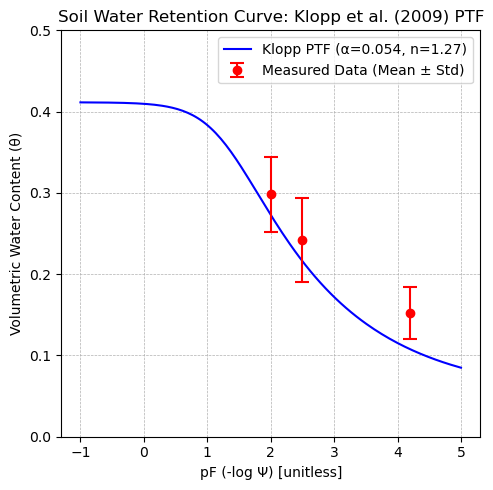

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "soil_data.xlsx"  # Ensure correct file path
df = pd.read_excel(file_path)

# Convert SOC from g/kg to % and compute OC (Organic Carbon)
df['SOC'] = df['SOC'] / 10

# Calculate additional variables
df['ESP'] = (100 * df['SAR']) / (1 + 0.0147 * df['SAR'])  # Empirical ESP formula
df['CEC'] = 25.219 + 0.132 * df['clay'] + 2.167e-2 * df['silt'] - 0.054 * df['sand'] - 2.2445 * df['pH'] + 0.865 * df['SOC']  # Khaledian et al., 2017


# Select relevant columns and remove missing values
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP', 'pH', 'SAR']
df = df.dropna(subset=features)  # Remove rows with missing values

# Compute mean values for soil properties
clay_mean = df["clay"].mean()
sand_mean = df["sand"].mean()
silt_mean = df["silt"].mean()
BD_mean = df["BD"].mean()
SOC_mean = df["SOC"].mean()
CEC_mean = df['CEC'].mean()
SAR_mean = df['SAR'].mean()
EC_mean = df['EC'].mean()

# Define the range of matric potential (Ψ)
psi_values = np.logspace(-1, 5, 150) * -1  # Negative values for suction
pF_values = np.log10(np.abs(psi_values))   # Convert suction to pF
# Define Rawls & Brakensiek (1985) equations from the image



# --- van Genuchten equation ---
def van_genuchten(h, theta_r, theta_s, alpha, n):
    m = 1 - 1/n
    return theta_r + (theta_s - theta_r) / ((1 + (-alpha * h)**n) ** m)



import numpy as np

def klopp_2021(sand, clay, CEC, SAR, EC):
    """
    Compute van Genuchten parameters from Klopp et al. (2021)
    Inputs:
        sand : Sand content (%)
        clay : Clay content (%)
        CEC  : Cation Exchange Capacity
        SAR  : Sodium Adsorption Ratio
        EC   : Electrical Conductivity
    Returns:
        theta_s, alpha, n
    """
    # Step 1: θ_33kPa
    theta_33 = 0.189 + 0.0072 * CEC + 0.0075 * (SAR / EC) - 0.00143 * sand

    # Step 2: θ_s
    theta_s = 0.41 + 0.0075 * theta_33

    # Step 3: α
    alpha = np.exp(-3.11 + 1.0 * theta_33)

    # Step 4: n
    n = np.exp(0.29 - 0.253 * theta_33)

    return theta_s, alpha, n




# Compute mean values
theta_s_rb2, alpha_rb2, n_rb2 = klopp_2021(sand_mean, clay_mean, CEC_mean, SAR_mean, EC_mean)
theta_r_rb2 = 0.05 

print(theta_s_rb2, alpha_rb2, n_rb2, theta_r_rb2)


# Compute θ(ψ) using new RB-1985 full equation
theta_rb2 = van_genuchten(psi_values, theta_r_rb2, theta_s_rb2, alpha_rb2, n_rb2)

theta_rb2


# teansfer θ(ψ) as DataFrame
theta_df = pd.DataFrame({
    "ψ (cm)": psi_values,
    "pF": pF_values,
    "θ (cm³/cm³)": theta_rb2
})

print(theta_df)

# --- Prepare measured data (means and std devs) ---
pF_measured = [2.0, 2.5, 4.2]  # pF for FC, FC_33, and PWP
theta_measured = [df["FC"].mean(), df["FC_33"].mean(), df["PWP"].mean()]
theta_std = [df["FC"].std(), df["FC_33"].std(), df["PWP"].std()]


# Plot
plt.figure(figsize=(5, 5))
plt.plot(pF_values, theta_rb2, label=f"Klopp PTF (α={alpha_rb2:.3f}, n={n_rb2:.2f})", linestyle="solid", color="blue")
# Overlay measured data points
plt.errorbar(pF_measured, theta_measured, yerr=theta_std, fmt='o', color="red", label="Measured Data (Mean ± Std)", capsize=5, capthick=1.5)

plt.xlabel("pF (-log Ψ) [unitless]")
plt.ylabel("Volumetric Water Content (θ)")
plt.title("Soil Water Retention Curve: Klopp et al. (2009) PTF")
plt.ylim(0, 0.5)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()



### Merge all water retention curves together

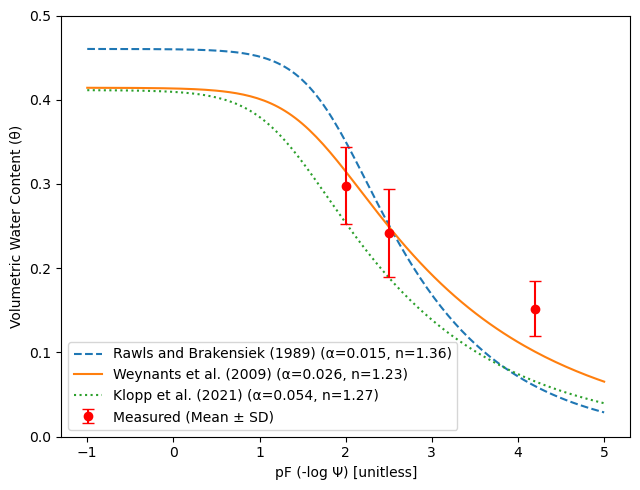

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel("soil_data.xlsx")

# Basic conversions and additional calculations
df['SOC'] = df['SOC'] / 10  # Convert from g/kg to %
df['ESP'] = (100 * df['SAR']) / (1 + 0.0147 * df['SAR'])
df['CEC'] = 25.219 + 0.132 * df['clay'] + 0.02167 * df['silt'] - 0.054 * df['sand'] - 2.2445 * df['pH'] + 0.865 * df['SOC']

# Remove missing data
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'FC', 'FC_33', 'PWP', 'pH', 'SAR']
df = df.dropna(subset=features)

# Mean values
clay_mean = df["clay"].mean()
sand_mean = df["sand"].mean()
silt_mean = df["silt"].mean()
BD_mean = df["BD"].mean()
SOC_mean = df["SOC"].mean()
CEC_mean = df['CEC'].mean()
SAR_mean = df['SAR'].mean()
EC_mean = df['EC'].mean()


# --- van Genuchten equation ---
def van_genuchten(h, theta_r, theta_s, alpha, n):
    m = 1 - 1/n
    return theta_r + (theta_s - theta_r) / ((1 + (-alpha * h)**n) ** m)



# Suction range
psi_values = np.logspace(-1, 5, 150) * -1
pF_values = np.log10(np.abs(psi_values))

# --- Rawls & Brakensiek (1985) ---
def rb1985_parameters(sand, clay, BD):
    if sand > 1 or clay > 1:
        sand = sand / 100
        clay = clay / 100
    phi = 1 - BD / 2.65
    theta_s = phi
    hb = np.exp(
        5.3396738 + 0.1845038 * clay - 2.483945 * phi
        - 0.00213853 * clay**2 - 0.04356349 * sand * phi
        - 0.61745089 * clay * phi + 0.00143598 * sand**2 * phi**2
        - 0.00855375 * clay**2 * phi**2 - 0.000012 * sand**2 * clay
        + 0.00895359 * clay**2 * phi - 0.00072472 * sand**2 * phi
        + 0.0000054 * clay**2 * sand + 0.5002806 * clay * phi**2
    )
    a = 1 / hb
    n = 1 + np.exp(
        -0.7842831 + 0.0177544 * sand - 1.062498 * phi
        - 0.00005304 * sand**2 - 0.00273493 * clay
        + 1.11134946 * phi**2 + 0.03088295 * sand * phi
        + 0.00026587 * sand**2 * phi**2 - 0.00610522 * clay**2 * phi**2
        - 0.00000235 * sand**2 * clay + 0.00798746 * clay**2 * phi
        - 0.0067449 * clay * phi**2
    )
    theta_r = (
        -0.0182482 + 0.00087269 * sand + 0.00513488 * clay
        + 0.02939286 * phi - 0.00015395 * clay**2
        - 0.0010827 * sand * phi - 0.00018233 * clay**2 * phi**2
        + 0.00030703 * clay**2 * phi - 0.0023594 * clay * phi**2
    )
    return theta_r, theta_s, a, n

# --- Weynants et al. (2009) ---
def weynants_2009(sand, clay, BD, SOC):
    theta_s = 0.6355 + 0.0013 * clay - 0.1631 * BD
    alpha = np.exp(-4.3003 - 0.0097 * clay + 0.0138 * sand - 0.0992 * SOC)
    n = np.exp(-1.0846 - 0.0236 * clay - 0.0085 * sand + 0.0001 * sand**2) + 1
    return theta_s, alpha, n

# --- Klopp et al. (2021) ---
def klopp_2021(sand, clay, CEC, SAR, EC):
    theta_33 = 0.189 + 0.0072 * CEC + 0.0075 * (SAR / EC) - 0.00143 * sand
    theta_s = 0.41 + 0.0075 * theta_33
    alpha = np.exp(-3.11 + 1.0 * theta_33)
    n = np.exp(0.29 - 0.253 * theta_33)
    return theta_s, alpha, n

# --- Vereecken et al. (1989)-like approximation using parameters from Weynants variant ---
def vereecken_1989_parameters(sand, clay, BD, SOC):
    # From Weynants-based simplification
    theta_s = 0.81 - 0.283 * BD + 0.001 * clay
    alpha = np.exp(-2.486 + 0.025 * sand - 0.351 * clay)
    n = np.exp(0.053 - 0.009 * sand - 0.013 * clay + 0.00015 * sand**2)
    theta_r = 0.015 + 0.005 * clay + 0.014 * SOC
    return theta_r, theta_s, alpha, n

# --- Calculate θ(ψ) for each model ---
theta_r_rb, theta_s_rb, alpha_rb, n_rb = rb1985_parameters(sand_mean, clay_mean, BD_mean)
theta_rb = van_genuchten(psi_values, theta_r_rb, theta_s_rb, alpha_rb, n_rb)

theta_s_wey, alpha_wey, n_wey = weynants_2009(sand_mean, clay_mean, BD_mean, SOC_mean)
theta_r_wey = 0
theta_wey = van_genuchten(psi_values, theta_r_wey, theta_s_wey, alpha_wey, n_wey)

theta_s_klo, alpha_klo, n_klo = klopp_2021(sand_mean, clay_mean, CEC_mean, SAR_mean, EC_mean)
theta_r_klo = 0
theta_klo = van_genuchten(psi_values, theta_r_klo, theta_s_klo, alpha_klo, n_klo)

theta_r_ver, theta_s_ver, alpha_ver, n_ver = vereecken_1989_parameters(sand_mean, clay_mean, BD_mean, SOC_mean)
theta_ver = van_genuchten(psi_values, theta_r_ver, theta_s_ver, alpha_ver, n_ver)

# --- Measured data points ---
pF_measured = [2.0, 2.5, 4.2]
theta_measured = [df["FC"].mean(), df["FC_33"].mean(), df["PWP"].mean()]
theta_std = [df["FC"].std(), df["FC_33"].std(), df["PWP"].std()]

# --- Plot ---
plt.figure(figsize=(6.5, 5))

plt.plot(pF_values, theta_rb, label=f"Rawls and Brakensiek (1989) (α={alpha_rb:.3f}, n={n_rb:.2f})", linestyle="--")
plt.plot(pF_values, theta_wey, label=f"Weynants et al. (2009) (α={alpha_wey:.3f}, n={n_wey:.2f})", linestyle="-")
plt.plot(pF_values, theta_klo, label=f"Klopp et al. (2021) (α={alpha_klo:.3f}, n={n_klo:.2f})", linestyle=":")

plt.errorbar(pF_measured, theta_measured, yerr=theta_std, fmt='o', color="red", label="Measured (Mean ± SD)", capsize=4)

plt.xlabel("pF (-log Ψ) [unitless]")
plt.ylabel("Volumetric Water Content (θ)")

plt.ylim(0, 0.5)

plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


## not mean but all values

df:41 rows


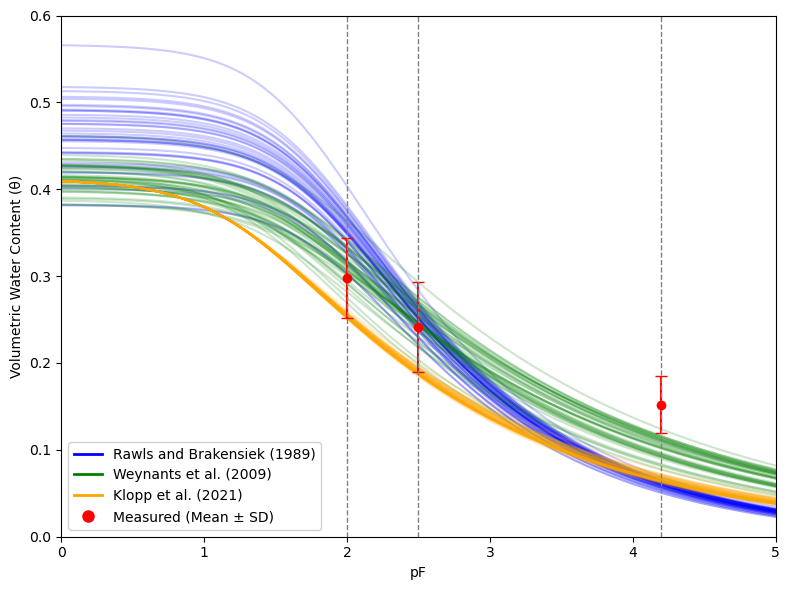

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel("soil_data.xlsx")

# Convert units and calculate derived parameters
df['SOC'] = df['SOC'] / 10  # from g/kg to %
df['ESP'] = (100 * df['SAR']) / (1 + 0.0147 * df['SAR'])
df['CEC'] = 25.219 + 0.132 * df['clay'] + 0.02167 * df['silt'] - 0.054 * df['sand'] - 2.2445 * df['pH'] + 0.865 * df['SOC']

# Drop rows with missing required values
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'pH', 'SAR', 'EC', 'FC', 'FC_33', 'PWP', ]
df = df.dropna(subset=features)
print(f"df:{len(df)} rows")

# Suction range
psi_values = np.logspace(-1, 5, 150) * -1  # from -0.1 to -100000 cm H2O
pF_values = np.log10(np.abs(psi_values))

# van Genuchten function
def van_genuchten(h, theta_r, theta_s, alpha, n):
    m = 1 - 1/n
    return theta_r + (theta_s - theta_r) / ((1 + (alpha * abs(h))**n) ** m)


# PTFs
def rb1985_parameters(sand, clay, BD):
    if sand > 1 or clay > 1:
        sand = sand / 100
        clay = clay / 100
        
    phi = 1 - BD / 2.65
    theta_s = phi
    
    # Bubbling pressure head (hb)
    hb = np.exp(
        5.3396738 + 0.1845038 * clay - 2.483945 * phi
        - 0.00213853 * clay**2 - 0.04356349 * sand * phi
        - 0.61745089 * clay * phi + 0.00143598 * sand**2 * phi**2
        - 0.00855375 * clay**2 * phi ** 2 - 0.00001282 * sand**2 * clay
        + 0.00895359 * clay**2 * phi - 0.00072472 * sand** 2 * phi
        + 0.0000054 * clay**2 * sand + 0.5002806 * clay * phi**2
    )

    a = 1 / hb  # van Genuchten α

    # n parameter
    n = 1 + np.exp(
        -0.7842831 + 0.0177544 * sand - 1.062498 * phi
        - 0.00005304 * sand**2 - 0.00273493 * clay
        + 1.11134946 * phi**2 + 0.03088295 * sand * phi
        + 0.00026587 * sand**2 * phi**2 - 0.00610522 * clay**2 * phi**2
        - 0.00000235 * sand**2 * clay + 0.00798746 * clay**2 * phi
        - 0.0067449 * clay * phi**2
    )

    # Residual water content (θr)
    theta_r = (
        -0.0182482 + 0.00087269 * sand + 0.00513488 * clay
        + 0.02939286 * phi - 0.00015395 * clay**2
        - 0.0010827 * sand * phi - 0.00018233 * clay**2 * phi**2
        + 0.00030703 * clay**2 * phi - 0.0023584 * clay * phi**2
    )

    return theta_r, theta_s, a, n



def weynants_2009(sand, clay, BD, SOC):
    theta_s = 0.6355 + 0.0013 * clay - 0.1631 * BD
    alpha = np.exp(-4.3003 - 0.0097 * clay + 0.0138 * sand - 0.0992 * SOC)
    n = np.exp(-1.0846 - 0.0236 * clay - 0.0085 * sand + 0.0001 * sand**2) + 1
    return theta_s, alpha, n

def klopp_2021(sand, clay, CEC, SAR, EC):
    theta_33 = 0.189 + 0.0072 * CEC + 0.0075 * (SAR / EC) - 0.00143 * sand
    theta_s = 0.41 + 0.0075 * theta_33
    alpha = np.exp(-3.11 + 1.0 * theta_33)
    n = np.exp(0.29 - 0.253 * theta_33)
    return theta_s, alpha, n

# --- Plot All Curves ---
plt.figure(figsize=(8, 6))

# Rawls & Brakensiek
for i, row in df.iterrows():
    try:
        theta_r, theta_s, alpha, n = rb1985_parameters(row['sand'], row['clay'], row['BD'])
        theta = van_genuchten(psi_values, theta_r, theta_s, alpha, n)
        plt.plot(pF_values, theta, color='blue', alpha=0.2, label='Rawls and Brakensiek (1989)' if i == 0 else "")
    except:
        continue

# Weynants et al.
for i, row in df.iterrows():
    try:
        theta_s, alpha, n = weynants_2009(row['sand'], row['clay'], row['BD'], row['SOC'])
        theta = van_genuchten(psi_values, 0, theta_s, alpha, n)
        plt.plot(pF_values, theta, color='green', alpha=0.2, label='Weynants et al. (2009)' if i == 0 else "")
    except:
        continue

# Klopp et al.
for i, row in df.iterrows():
    try:
        theta_s, alpha, n = klopp_2021(row['sand'], row['clay'], row['CEC'], row['SAR'], row['EC'])
        theta = van_genuchten(psi_values, 0, theta_s, alpha, n)
        plt.plot(pF_values, theta, color='orange', alpha=0.2, label='Klopp et al. (2021)' if i == 0 else "")
    except:
        continue

# Measured values with error bars
pF_measured = [2.0, 2.5, 4.2]
theta_measured = [df["FC"].mean(), df["FC_33"].mean(), df["PWP"].mean()]
theta_std = [df["FC"].std(), df["FC_33"].std(), df["PWP"].std()]
plt.errorbar(pF_measured, theta_measured, yerr=theta_std, fmt='o', color='red', label='Measured (Mean ± SD)', capsize=4)

# Plot details
plt.xlabel("pF")
plt.ylabel("Volumetric Water Content (θ)")

plt.ylim(0, 0.6)
plt.xlim(0, 5)


# 添加垂直虚线
for pf in [2.0, 2.5, 4.2]:
    plt.axvline(x=pf, color='gray', linestyle='--', linewidth=1)

from matplotlib.lines import Line2D

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Rawls and Brakensiek (1989)'),
    Line2D([0], [0], color='green', lw=2, label='Weynants et al. (2009)'),
    Line2D([0], [0], color='orange', lw=2, label='Klopp et al. (2021)'),
    Line2D([0], [0], marker='o', color='red', label='Measured (Mean ± SD)',
           markerfacecolor='red', markersize=8, linestyle='None')
]

plt.legend(handles=legend_elements, loc='lower left', frameon=True, fancybox=True, framealpha=0.9)

    

plt.grid(False)
plt.tight_layout()
plt.savefig("water_retention_curves_all_samples.png", dpi=600)
plt.show()




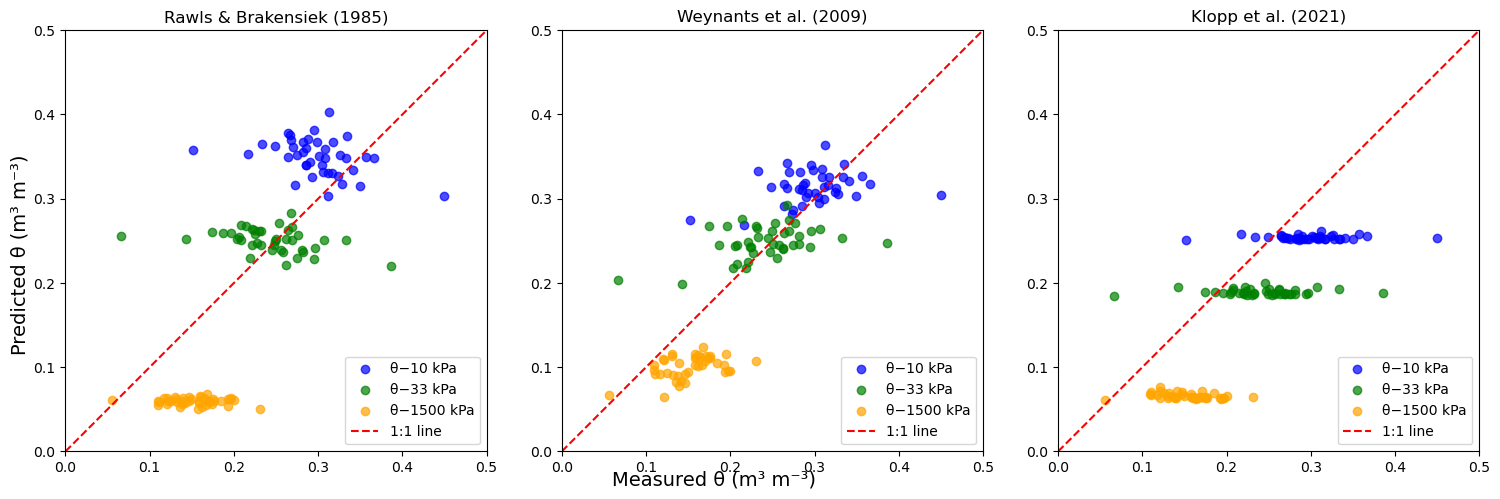

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Define target pF and corresponding suction (cm H2O)
target_pF = [2.0, 2.5, 4.2]
target_psi = -10 ** np.array(target_pF)

# Array of measured values
measured_points = {
    2.0: df["FC"],
    2.5: df["FC_33"],
    4.2: df["PWP"]
}

# Initialize the dictionary to store the predicted values
rb_preds = {pf: [] for pf in target_pF}
wy_preds = {pf: [] for pf in target_pF}
kp_preds = {pf: [] for pf in target_pF}

# Traverse the data rows for prediction
for _, row in df.iterrows():
    try:
        # Rawls & Brakensiek
        theta_r, theta_s, alpha, n = rb1985_parameters(row['sand'], row['clay'], row['BD'])
        pred_rb = van_genuchten(target_psi, theta_r, theta_s, alpha, n)
        for i, pf in enumerate(target_pF):
            rb_preds[pf].append(pred_rb[i])

        # Weynants
        theta_s, alpha, n = weynants_2009(row['sand'], row['clay'], row['BD'], row['SOC'])
        pred_wy = van_genuchten(target_psi, 0, theta_s, alpha, n)
        for i, pf in enumerate(target_pF):
            wy_preds[pf].append(pred_wy[i])

        # Klopp
        theta_s, alpha, n = klopp_2021(row['sand'], row['clay'], row['CEC'], row['SAR'], row['EC'])
        pred_kp = van_genuchten(target_psi, 0, theta_s, alpha, n)
        for i, pf in enumerate(target_pF):
            kp_preds[pf].append(pred_kp[i])
    except:
        continue

        import matplotlib.pyplot as plt
import numpy as np

# Color and label definitions
colors = {2.0: 'blue', 2.5: 'green', 4.2: 'orange'}
labels = {2.0: 'θ−10 kPa', 2.5: 'θ−33 kPa', 4.2: 'θ−1500 kPa'}

# Model list (dictionary structure, title)
models = [
    (rb_preds, "Rawls & Brakensiek (1985)"),
    (wy_preds, "Weynants et al. (2009)"),
    (kp_preds, "Klopp et al. (2021)")
]

# Creating a sub-image canvas
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Traverse each model to draw
for ax, (preds_dict, title) in zip(axs, models):
    for pf in [2.0, 2.5, 4.2]:
        y_true = measured_points[pf]
        y_pred = np.array(preds_dict[pf])[:len(y_true)]

        ax.scatter(y_true, y_pred, color=colors[pf], label=labels[pf], alpha=0.7)

    # Add 1:1 line
    line = np.linspace(0, 1, 100)
    ax.plot(line, line, 'r--', label='1:1 line')

    ax.set_title(title)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 0.5)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')

# Add overall x and y axis labels
fig.text(0.5, 0.04, 'Measured θ (m³ m⁻³)', ha='center', fontsize=14)
fig.text(0.06, 0.5, 'Predicted θ (m³ m⁻³)', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0.06, 0.05, 1, 1])
plt.savefig("predicted_vs_measured_rawls_weynants_klopp.png", dpi=600)
plt.show()


In [12]:
# Preparation
def compute_error_metrics(observed, predicted):
    me = np.mean(predicted - observed)
    rmse = np.sqrt(np.mean((predicted - observed)**2))
    nrmse = rmse / np.mean(observed) * 100
    return me, rmse, nrmse

#Information of matric (unit cm)
metrics_info = [
    ('θ–10 kPa', 'FC', 100),
    ('θ–33 kPa', 'FC_33', 330),
    ('θ–1500 kPa', 'PWP', 150000)
]

#Loop
all_results = []

for label, col, h in metrics_info:
    obs = df[col].values

    # Rawls & Brakensiek (1985)
    rb_pred = []
    for i, row in df.iterrows():
        try:
            theta_r, theta_s, alpha, n = rb1985_parameters(row['sand'], row['clay'], row['BD'])
            rb_pred.append(van_genuchten(h, theta_r, theta_s, alpha, n))
        except:
            rb_pred.append(np.nan)
    rb_pred = np.array(rb_pred)
    me, rmse, nrmse = compute_error_metrics(obs[~np.isnan(rb_pred)], rb_pred[~np.isnan(rb_pred)])
    all_results.append({'Model': 'Rawls & Brakensiek (1985)', 'Pressure': label, 'ME': me, 'RMSE': rmse, 'NRMSE (%)': nrmse})

    # Weynants (2009)
    wey_pred = []
    for i, row in df.iterrows():
        try:
            theta_s, alpha, n = weynants_2009(row['sand'], row['clay'], row['BD'], row['SOC'])
            wey_pred.append(van_genuchten(h, 0, theta_s, alpha, n))
        except:
            wey_pred.append(np.nan)
    wey_pred = np.array(wey_pred)
    me, rmse, nrmse = compute_error_metrics(obs[~np.isnan(wey_pred)], wey_pred[~np.isnan(wey_pred)])
    all_results.append({'Model': 'Weynants et al. (2009)', 'Pressure': label, 'ME': me, 'RMSE': rmse, 'NRMSE (%)': nrmse})

    # Klopp (2021)
    klopp_pred = []
    for i, row in df.iterrows():
        try:
            theta_s, alpha, n = klopp_2021(row['sand'], row['clay'], row['CEC'], row['SAR'], row['EC'])
            klopp_pred.append(van_genuchten(h, 0, theta_s, alpha, n))
        except:
            klopp_pred.append(np.nan)
    klopp_pred = np.array(klopp_pred)
    me, rmse, nrmse = compute_error_metrics(obs[~np.isnan(klopp_pred)], klopp_pred[~np.isnan(klopp_pred)])
    all_results.append({'Model': 'Klopp et al. (2021)', 'Pressure': label, 'ME': me, 'RMSE': rmse, 'NRMSE (%)': nrmse})

# Display results
results_df = pd.DataFrame(all_results)
results_df[['ME', 'RMSE']] = results_df[['ME', 'RMSE']].round(4)
results_df['NRMSE (%)'] = results_df['NRMSE (%)'].round(2)
results_df

,Model,Pressure,ME,RMSE,NRMSE (%)
0,Rawls & Brakensiek (1985),θ–10 kPa,0.0513,0.0770,25.83
1,Weynants et al. (2009),θ–10 kPa,0.0158,0.0465,15.61
2,Klopp et al. (2021),θ–10 kPa,-0.0440,0.0631,21.17
3,Rawls & Brakensiek (1985),θ–33 kPa,0.0053,0.0578,23.89
4,Weynants et al. (2009),θ–33 kPa,0.0042,0.0459,18.98
5,Klopp et al. (2021),θ–33 kPa,-0.0548,0.0749,30.95
6,Rawls & Brakensiek (1985),θ–1500 kPa,-0.1280,0.1320,86.73
7,Weynants et al. (2009),θ–1500 kPa,-0.0928,0.0972,63.86
8,Klopp et al. (2021),θ–1500 kPa,-0.1163,0.1208,79.36


## Combine all plots based on soil water retentions together

df:41 rows


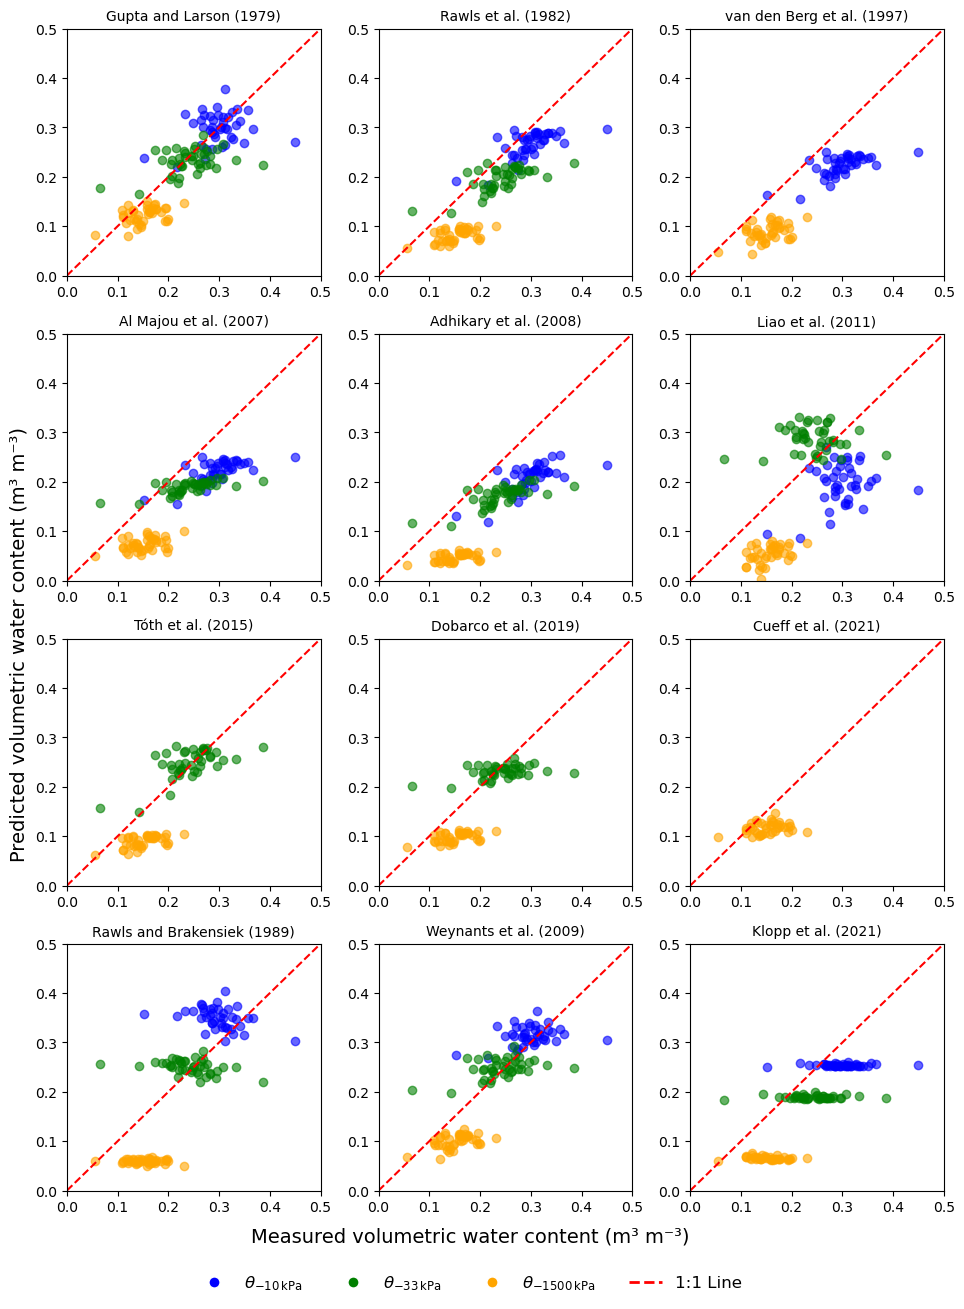

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data and preprocess
df = pd.read_excel("soil_data.xlsx")
df['SOC'] = df['SOC'] / 10
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'pH', 'FC', 'FC_33', 'PWP']
df = df.dropna(subset=features)
print(f"df:{len(df)} rows")
    
# Literature model prediction
df['pwp_Rawls1982'] = 0.0260 + 0.0050 * df['clay'] + 0.009164 * df['SOC']
df['fc33_Rawls1982'] = 0.2391 - 0.0019 * df['sand'] + 0.01218 * df['SOC'] + 0.72 * df['pwp_Rawls1982']

df['fc10_Gupta1979'] = 0.005018*df['sand'] + 0.008548*df['silt'] + 0.008833*df['clay'] + 0.00288051 *df['SOC'] - 0.2423*df['BD']
df['fc33_Gupta1979'] = 0.003075*df['sand'] + 0.005886*df['silt'] + 0.008039*df['clay'] + 0.00128074 *df['SOC'] - 0.1434*df['BD']
df['pwp_Gupta1979'] = -0.000059 *df['sand'] + 0.001142 *df['silt'] + 0.005766*df['clay'] + 0.00129234 *df['SOC'] + 0.02671*df['BD']

df['fc10_Rawls1982'] = 0.0619 - 0.0002 * df['sand'] - 0.003886 * df['SOC'] + 1.34 * df['fc33_Rawls1982'] - 0.51 * df['pwp_Rawls1982']
df['pwp_Vandenberg1997'] = 0.00334 * df['clay'] * df['BD'] + 0.00104 * df['silt'] * df['BD']
df['fc10_Vandenberg1997'] = 0.1088 + 0.00347 * df['clay'] + 0.00211 * df['silt'] + 0.01756 * df['SOC']

df['fc10_Almajou2007'] = df['fc10_Vandenberg1997']
df['fc33_Almajou2007'] = 0.1301 + 0.0038 * df['clay'] + 0.0012 *df['silt'] + 0.0010 * df['SOC'] - 0.0084  * df['BD']
df['pwp_Almajou2007'] = -0.0786 + 0.0045 * df['clay'] + 0.0003 * df['silt'] + 0.0004 * df['SOC'] + 0.0710 * df['BD']

df['fc10_Adhikary2008'] = 0.6250 - 0.0058 * df['sand'] - 0.0021 * df['silt']
df['fc33_Adhikary2008'] = 0.5637 - 0.0051 * df['sand'] - 0.0027 * df['silt']
df['pwp_Adhikary2008'] = 0.0071 + 0.0044 * df['clay']

df['fc10_Liao2011'] = (
    -2.44344 + 2.128 * df['BD'] + 0.275 * np.log(df['sand']) + 0.068 * np.log(df['SOC']) +
    0.00013 * df['silt']**2 - 0.808 * df['BD']**2 - 0.00003364 * df['sand'] * df['SOC'] +
    0.00008 * (df['BD']**2) * (df['clay']**2)
)
df['fc33_Liao2011'] = (
    -1.88394 + 3.158 * df['BD'] + 0.042 * np.log(df['SOC']) -
    1.139 * df['BD']**2 - 0.000058 * df['sand'] * df['SOC'] +
    0.000058 * df['silt'] * df['SOC']
)
df['pwp_Liao2011'] = (
    0.159075 + 0.025 * np.log(df['SOC']) - 0.00012 * df['silt']**2 -
    0.092 * df['BD']**2 - 0.000085 * df['sand'] * df['silt'] +
    0.0000174 * df['silt'] * df['SOC'] + 0.008 * df['silt'] * df['BD'] +
    0.00069606 * df['BD'] * df['SOC']
)

df['fc33_Toth2015'] = (
    0.2449 - 0.1887 / (df['SOC']+1) + 0.004527 * df['clay'] +
    0.001535 * df['silt'] + 0.001442 * df['silt'] / (df['SOC']+1) -
    0.00005110 * df['silt'] * df['clay'] + 0.0008676 * df['clay'] / (df['SOC']+1)
)
df['pwp_Toth2015'] = (
    0.09878 + 0.002127 * df['clay'] - 0.0008366 * df['silt'] -
    0.07670 / (df['SOC']+1) + 0.00003853 * df['silt'] * df['clay'] +
    0.002330 * df['clay'] / (df['SOC']+1) + 0.0009498 * df['silt'] / (df['SOC']+1)
)

df['fc33_Dobarco2019'] = 0.394 + 0.00229 * df['clay'] - 0.00124 * df['sand'] - 0.0758 * df['BD']
df['pwp_Dobarco2019'] = 0.074 + 0.00412 * df['clay'] - 0.000241 * df['sand'] + 0.00128 * df['SOC']
df['pwp_Cueff2021'] = 0.145 + 0.00256 * df['clay'] - 0.0856 * df['BD'] + 0.007 * df['pH'] + 0.000624 * df['silt']

# van Genuchten model predictions (the three groups calculated earlier)
# measured_points = {2.0: df["FC"], 2.5: df["FC_33"], 4.2: df["PWP"]}
# rb_preds, wy_preds, kp_preds should also be populated

# All model configurations
models = [
    ('fc10_Gupta1979', 'fc33_Gupta1979', 'pwp_Gupta1979', 'Gupta and Larson (1979)'),
    ('fc10_Rawls1982', 'fc33_Rawls1982', 'pwp_Rawls1982', 'Rawls et al. (1982)'),
    ('fc10_Vandenberg1997', None, 'pwp_Vandenberg1997', 'van den Berg et al. (1997)'),
    ('fc10_Almajou2007', 'fc33_Almajou2007', 'pwp_Almajou2007', 'Al Majou et al. (2007)'),
    ('fc10_Adhikary2008', 'fc33_Adhikary2008', 'pwp_Adhikary2008', 'Adhikary et al. (2008)'),
    ('fc10_Liao2011', 'fc33_Liao2011', 'pwp_Liao2011', 'Liao et al. (2011)'),
    (None, 'fc33_Toth2015', 'pwp_Toth2015', 'Tóth et al. (2015)'),
    (None, 'fc33_Dobarco2019', 'pwp_Dobarco2019', 'Dobarco et al. (2019)'),
    (None, None, 'pwp_Cueff2021', 'Cueff et al. (2021)'),
    ('rb_preds', None, None, 'Rawls and Brakensiek (1989)'),
    ('wy_preds', None, None, 'Weynants et al. (2009)'),
    ('kp_preds', None, None, 'Klopp et al. (2021)')
]

colors = {'FC10': 'blue', 'FC33': 'green', 'PWP': 'orange'}
fig, axs = plt.subplots(4, 3, figsize=(10, 13))

for ax, (fc10, fc33, pwp, title) in zip(axs.flatten(), models):
    # van Genuchten model
    if fc10 == 'rb_preds':
        for pf, color, label in zip([2.0, 2.5, 4.2], ['blue', 'green', 'orange'], ['θ−10 kPa', 'θ−33 kPa', 'θ−1500 kPa']):
            y_true = df["FC"] if pf == 2.0 else df["FC_33"] if pf == 2.5 else df["PWP"]
            y_pred = np.array(rb_preds[pf])[:len(y_true)]
            ax.scatter(y_true, y_pred, color=color, label=label, alpha=0.6)
    elif fc10 == 'wy_preds':
        for pf, color, label in zip([2.0, 2.5, 4.2], ['blue', 'green', 'orange'], ['θ−10 kPa', 'θ−33 kPa', 'θ−1500 kPa']):
            y_true = df["FC"] if pf == 2.0 else df["FC_33"] if pf == 2.5 else df["PWP"]
            y_pred = np.array(wy_preds[pf])[:len(y_true)]
            ax.scatter(y_true, y_pred, color=color, label=label, alpha=0.6)
    elif fc10 == 'kp_preds':
        for pf, color, label in zip([2.0, 2.5, 4.2], ['blue', 'green', 'orange'], ['θ−10 kPa', 'θ−33 kPa', 'θ−1500 kPa']):
            y_true = df["FC"] if pf == 2.0 else df["FC_33"] if pf == 2.5 else df["PWP"]
            y_pred = np.array(kp_preds[pf])[:len(y_true)]
            ax.scatter(y_true, y_pred, color=color, label=label, alpha=0.6)
    else:
        if fc10:
            ax.scatter(df['FC'], df[fc10], color=colors['FC10'], alpha=0.6, label='θ−10 kPa')
        if fc33:
            ax.scatter(df['FC_33'], df[fc33], color=colors['FC33'], alpha=0.6, label='θ−33 kPa')
        if pwp:
            ax.scatter(df['PWP'], df[pwp], color=colors['PWP'], alpha=0.6, label='θ−1500 kPa')
    
    ax.plot([0, 0.5], [0, 0.5], 'r--')
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, 0.5)
    ax.set_title(title, fontsize=10)

# add axis labels
fig.text(0.5, 0.04, 'Measured volumetric water content (m³ m⁻³)', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted volumetric water content (m³ m⁻³)', va='center', rotation='vertical', fontsize=14)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=r'$\theta_{-10\,\mathrm{kPa}}$', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=r'$\theta_{-33\,\mathrm{kPa}}$', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=r'$\theta_{-1500\,\mathrm{kPa}}$', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='1:1 Line')
]


# Add shared legend below
fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.01),
           bbox_transform=fig.transFigure,
           ncol=4,
           frameon=False,
           fontsize=12)


plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig("ptf_models_vs_measured_all.png", dpi=1000)
plt.show()


## Summary the dataset

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


# Read the data
df = pd.read_excel("soil_data.xlsx")

# Convert SOC from g/kg to %
df['SOC'] = df['SOC'] / 10

# Rename columns for soil water content at different kPa levels
df['θ-10 kPa'] = df['FC']
df['θ-33 kPa'] = df['FC_33']
df['θ-1500 kPa'] = df['PWP']

df['CEC'] = 25.219 + 0.132 * df['clay'] + 0.02167 * df ['silt'] - 0.054 * df ['sand'] - 2.2445 * df['pH'] + 0.865 * df['SOC']

# Select feature variables
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'Ka', 'EC', 'SAR', 'WR', 'pH', 'FC', 'FC_33', 'PWP']

# Remove rows with NaN values in the selected feature columns
df = df.dropna(subset=features)

# Select only the feature variables for calculating correlation
df_features = df[features]

# Calculate descriptive statistics
descriptive_stats = df_features.describe().T

# Select the required statistics
descriptive_stats = descriptive_stats[['min', 'max', 'mean', 'std']]

# Output the result
print(descriptive_stats)

# Save the result to a CSV file
descriptive_stats.to_csv('descriptive_statistics.csv', index=True)


             min         max       mean        std
SOC     0.228000    2.458000   1.113976   0.549765
sand   49.611824   83.618767  61.244285   6.927561
silt   10.052122   42.206814  29.507466   5.724024
clay    5.592007   12.341063   9.248248   1.902133
BD      1.148851    1.638689   1.430221   0.103176
Ka      0.000000   67.947421   6.504163  12.317966
EC      0.088067    0.245000   0.153276   0.042092
SAR     0.139694    2.333199   0.756635   0.524683
WR      6.250000  103.500000  28.786585  21.178967
pH      6.890000    7.880000   7.465610   0.260327
FC      0.151800    0.449700   0.298107   0.045873
FC_33   0.066300    0.385900   0.241956   0.051788
PWP     0.055700    0.230800   0.152167   0.032339


### Explore the correlations

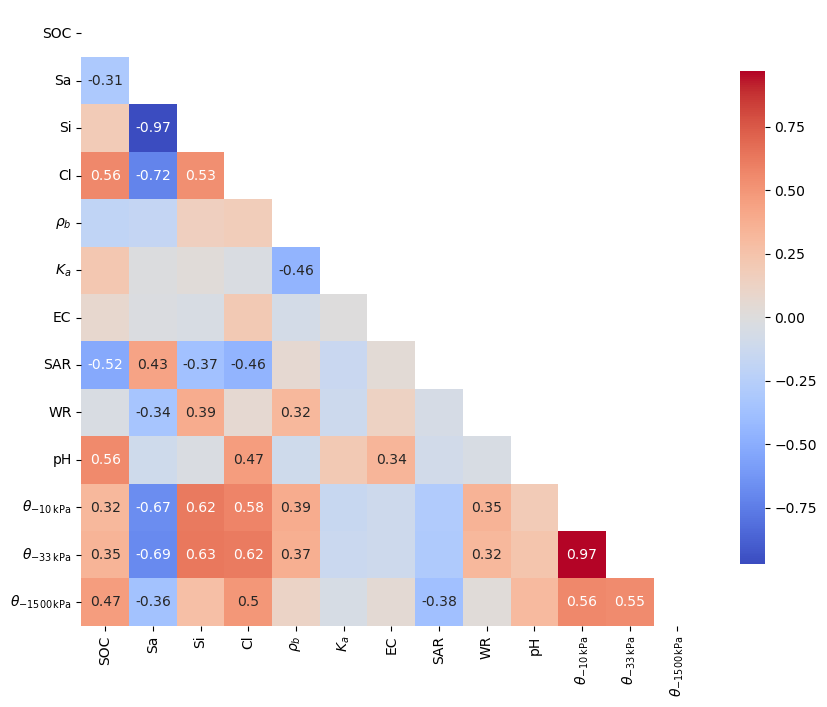

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Original feature list
features = ['SOC', 'sand', 'silt', 'clay', 'BD', 'Ka', 'EC', 'SAR', 'WR', 'pH', 'θ-10 kPa', 'θ-33 kPa', 'θ-1500 kPa']



# Mapping original variable names to pretty LaTeX-style labels
display_mapping = {
    'Ka': r"$K_a$",
    'BD': r"$ρ_b$",
    'sand': r"Sa",
    'silt': r"Si",
    'clay': r"Cl",
    'θ-10 kPa': r"$\theta_{-10\,\mathrm{kPa}}$",
    'θ-33 kPa': r"$\theta_{-33\,\mathrm{kPa}}$",
    'θ-1500 kPa': r"$\theta_{-1500\,\mathrm{kPa}}$"
}

# Create display names list with mapping applied
display_features = [display_mapping.get(f, f) for f in features]

# Prepare data
df = df.dropna(subset=features)
df_features = df[features]
corr_matrix = df_features.corr()

# Compute p-value matrix
pval_matrix = pd.DataFrame(index=features, columns=features)
for row in features:
    for col in features:
        _, pval_matrix.loc[row, col] = pearsonr(df_features[row], df_features[col])

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Annotate only significant values
annot = pd.DataFrame('', index=features, columns=features)
for row in features:
    for col in features:
        if pval_matrix.loc[row, col] < 0.05 and row != col:
            annot.loc[row, col] = str(round(corr_matrix.loc[row, col], 2))
        else:
            annot.loc[row, col] = ''

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=annot,
            fmt='',
            cmap='coolwarm',
            mask=mask,
            xticklabels=display_features,
            yticklabels=display_features,
            cbar_kws={"shrink": .8})

plt.savefig('correlation_heatmap.png', dpi=600, bbox_inches='tight')
plt.show()


## LOOSV methods

## Overall with TWW-realetd indicatorfrom scipy.stats import pearsonr

In [29]:
from scipy.stats import pearsonr

target_vars = ['θ-10 kPa', 'θ-33 kPa', 'θ-1500 kPa']

for target in target_vars:
    print(f"\nCorrelations with {target}")
    
    for feature in features:
        if feature not in target_vars:
            r, p = pearsonr(df[feature], df[target])
            r_squared = r**2
            print(f"  {feature}: r = {r:.2f}, R² = {r_squared:.2f}, p = {p:.3f}")



Correlations with θ-10 kPa
  SOC: r = 0.32, R² = 0.10, p = 0.041
  sand: r = -0.67, R² = 0.45, p = 0.000
  silt: r = 0.62, R² = 0.39, p = 0.000
  clay: r = 0.58, R² = 0.33, p = 0.000
  BD: r = 0.39, R² = 0.15, p = 0.012
  Ka: r = -0.15, R² = 0.02, p = 0.341
  EC: r = -0.11, R² = 0.01, p = 0.490
  SAR: r = -0.29, R² = 0.08, p = 0.068
  WR: r = 0.35, R² = 0.12, p = 0.024
  pH: r = 0.19, R² = 0.04, p = 0.223

Correlations with θ-33 kPa
  SOC: r = 0.35, R² = 0.12, p = 0.027
  sand: r = -0.69, R² = 0.47, p = 0.000
  silt: r = 0.63, R² = 0.39, p = 0.000
  clay: r = 0.62, R² = 0.38, p = 0.000
  BD: r = 0.37, R² = 0.14, p = 0.017
  Ka: r = -0.14, R² = 0.02, p = 0.396
  EC: r = -0.11, R² = 0.01, p = 0.485
  SAR: r = -0.30, R² = 0.09, p = 0.059
  WR: r = 0.32, R² = 0.10, p = 0.042
  pH: r = 0.24, R² = 0.06, p = 0.132

Correlations with θ-1500 kPa
  SOC: r = 0.47, R² = 0.22, p = 0.002
  sand: r = -0.36, R² = 0.13, p = 0.021
  silt: r = 0.27, R² = 0.07, p = 0.086
  clay: r = 0.50, R² = 0.25, p = 

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Drop target variables if any; here we assume all are features
X = df[features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

X = df[features].drop(columns=target_vars)
y = df['θ-10 kPa']  # or θ-10, θ-1500 etc.

# Standardize again if needed
X_scaled = StandardScaler().fit_transform(X)

# Run LASSO to select features
lasso = LassoCV(cv=5).fit(X_scaled, y)

# Show non-zero coefficient features
selected_features = pd.Series(lasso.coef_, index=X.columns)
print("Selected features:\n", selected_features[selected_features != 0])


Selected features:
 SOC     0.004697
sand   -0.020793
clay    0.003983
BD      0.010201
Ka     -0.001740
EC     -0.005941
WR      0.004435
pH      0.003987
dtype: float64


In [32]:
from sklearn.linear_model import LassoCV

X = df[features].drop(columns=target_vars)
y = df['θ-33 kPa']  # or θ-10, θ-1500 etc.

# Standardize again if needed
X_scaled = StandardScaler().fit_transform(X)

# Run LASSO to select features
lasso = LassoCV(cv=5).fit(X_scaled, y)

# Show non-zero coefficient features
selected_features = pd.Series(lasso.coef_, index=X.columns)
print("Selected features:\n", selected_features[selected_features != 0])


Selected features:
 SOC     0.004188
sand   -0.023646
clay    0.006971
BD      0.010511
Ka     -0.002796
EC     -0.009141
WR      0.004535
pH      0.007890
dtype: float64


In [33]:
from sklearn.linear_model import LassoCV

X = df[features].drop(columns=target_vars)
y = df['θ-1500 kPa']  # or θ-10, θ-1500 etc.

# Standardize again if needed
X_scaled = StandardScaler().fit_transform(X)

# Run LASSO to select features
lasso = LassoCV(cv=5).fit(X_scaled, y)

# Show non-zero coefficient features
selected_features = pd.Series(lasso.coef_, index=X.columns)
print("Selected features:\n", selected_features[selected_features != 0])


Selected features:
 SOC     0.005824
clay    0.008275
SAR    -0.001871
dtype: float64


## With TWW indicators


 Model Evaluation:
R²: 0.576
RMSE: 0.0295 m³/m³
NRMSE: 9.89%

 Regression Equation in Original Units:
θ-10 kPa = 0.2627 - 0.0032 × sand + 0.0014 × clay + 0.0166 × SOC + 0.1354 × BD + 0.0002 × WR

 Coefficients (original scale):
  sand: -0.003201
  clay: 0.001445
  SOC: 0.016620
  BD: 0.135362
  WR: 0.000205
  Intercept: 0.262735


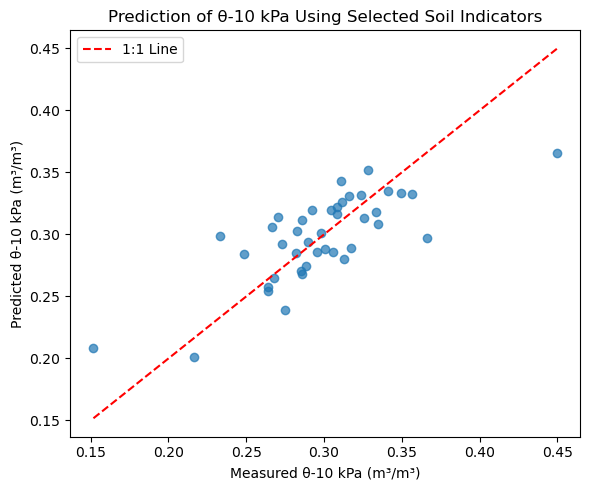

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['sand', 'clay', 'SOC', 'BD', 'WR']
X = df[selected_features]
y = df['θ-10 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100


# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-10 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-10 kPa (m³/m³)")
plt.ylabel("Predicted θ-10 kPa (m³/m³)")
plt.title("Prediction of θ-10 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



 Model Evaluation:
R²: 0.590
RMSE: 0.0328 m³/m³
NRMSE: 13.54%

 Regression Equation in Original Units:
θ-33 kPa = 0.1994 - 0.0035 × sand + 0.0034 × clay + 0.0177 × SOC + 0.1409 × BD + 0.0002 × WR

 Coefficients (original scale):
  sand: -0.003505
  clay: 0.003364
  SOC: 0.017656
  BD: 0.140881
  WR: 0.000171
  Intercept: 0.199416


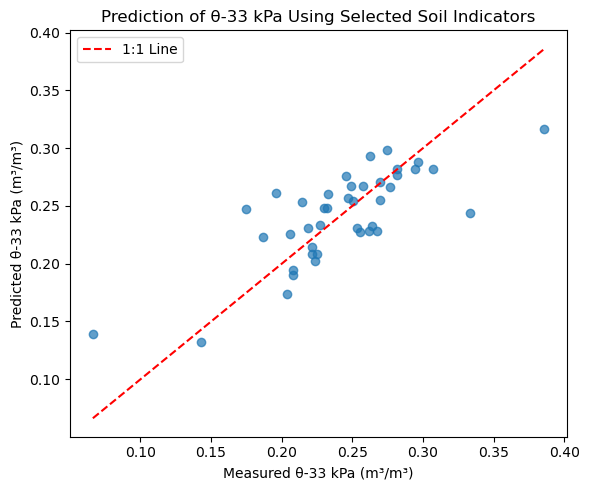

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['sand', 'clay', 'SOC', 'BD', 'WR']
X = df[selected_features]
y = df['θ-33 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100

# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-33 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-33 kPa (m³/m³)")
plt.ylabel("Predicted θ-33 kPa (m³/m³)")
plt.title("Prediction of θ-33 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



 Model Evaluation:
R²: 0.306
RMSE: 0.0266 m³/m³
NRMSE: 17.49%

 Regression Equation in Original Units:
θ-1500 kPa = 0.0934 - 0.0072 × SAR + 0.0053 × clay + 0.0134 × SOC

 Coefficients (original scale):
  SAR: -0.007164
  clay: 0.005324
  SOC: 0.013442
  Intercept: 0.093372


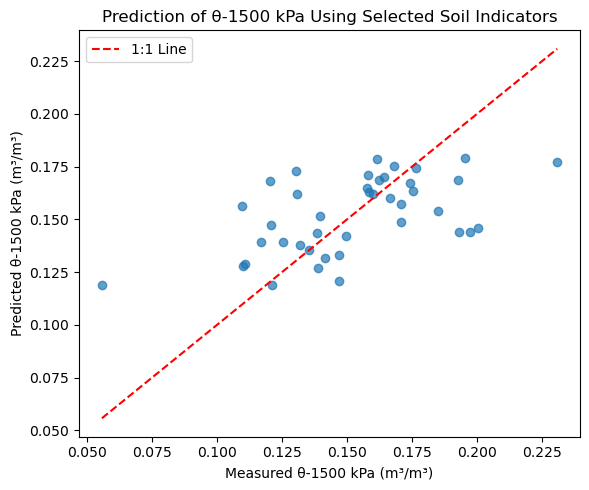

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['SAR', 'clay', 'SOC']
X = df[selected_features]
y = df['θ-1500 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100

# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-1500 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-1500 kPa (m³/m³)")
plt.ylabel("Predicted θ-1500 kPa (m³/m³)")
plt.title("Prediction of θ-1500 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


## Predict without TWW indicator


 Model Evaluation:
R²: 0.570
RMSE: 0.0297 m³/m³
NRMSE: 9.97%

 Regression Equation in Original Units:
θ-10 kPa = 0.2812 - 0.0036 × sand + 0.0004 × clay + 0.0174 × SOC + 0.1487 × BD

 Coefficients (original scale):
  sand: -0.003570
  clay: 0.000376
  SOC: 0.017423
  BD: 0.148706
  Intercept: 0.281164


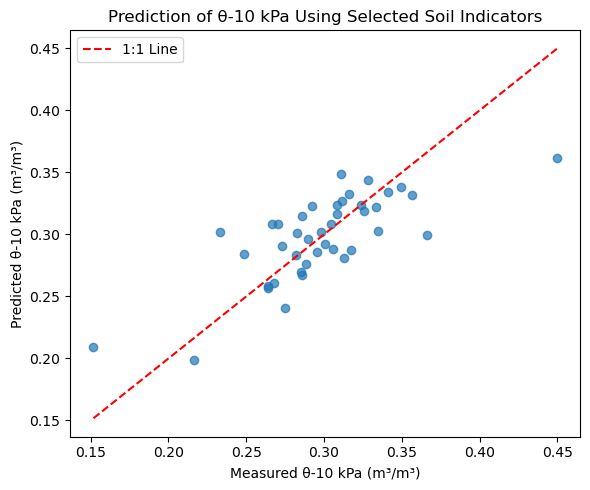

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['sand', 'clay', 'SOC', 'BD']
X = df[selected_features]
y = df['θ-10 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100


# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-10 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-10 kPa (m³/m³)")
plt.ylabel("Predicted θ-10 kPa (m³/m³)")
plt.title("Prediction of θ-10 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



 Model Evaluation:
R²: 0.586
RMSE: 0.0329 m³/m³
NRMSE: 13.60%

 Regression Equation in Original Units:
θ-10 kPa = 0.2147 - 0.0038 × sand + 0.0025 × clay + 0.0183 × SOC + 0.1520 × BD

 Coefficients (original scale):
  sand: -0.003812
  clay: 0.002474
  SOC: 0.018325
  BD: 0.151979
  Intercept: 0.214745


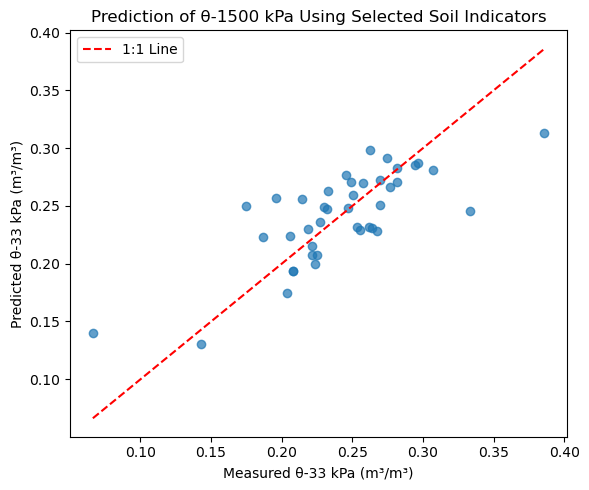

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['sand', 'clay', 'SOC', 'BD']
X = df[selected_features]
y = df['θ-33 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100


# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-10 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-33 kPa (m³/m³)")
plt.ylabel("Predicted θ-33 kPa (m³/m³)")
plt.title("Prediction of θ-33 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



 Model Evaluation:
R²: 0.296
RMSE: 0.0268 m³/m³
NRMSE: 17.61%

 Regression Equation in Original Units:
θ-10 kPa = 0.0805 + 0.0058 × clay + 0.0161 × SOC

 Coefficients (original scale):
  clay: 0.005810
  SOC: 0.016064
  Intercept: 0.080539


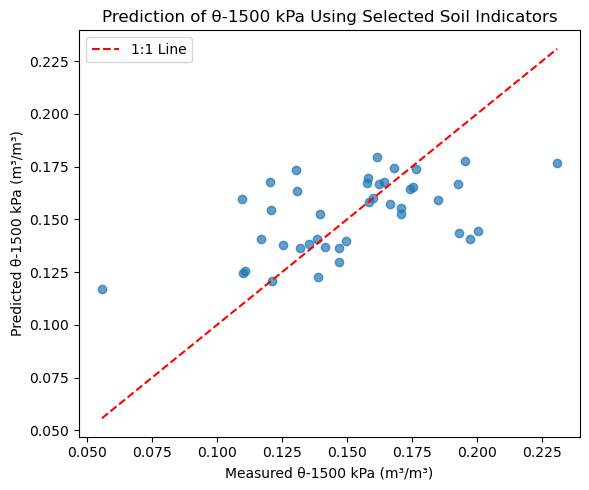

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Select features and target
selected_features = ['clay', 'SOC']
X = df[selected_features]
y = df['θ-1500 kPa']

# Step 2: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
means = scaler.mean_
stds = np.sqrt(scaler.var_)

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Step 4: Predict and evaluate
y_pred = model.predict(X_scaled)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
nrmse = (rmse / np.mean(y)) * 100


# Step 5: Extract coefficients and reverse-standardize
beta_0 = model.intercept_
betas = model.coef_
a_coeffs = betas / stds
a0 = beta_0 - np.sum((betas * means) / stds)

# Step 6: Print model output
print("\n Model Evaluation:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.4f} m³/m³")
print(f"NRMSE: {nrmse:.2f}%")


print("\n Regression Equation in Original Units:")
print(f"θ-10 kPa = {a0:.4f}", end="")
for coef, name in zip(a_coeffs, selected_features):
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} × {name}", end="")
print()

print("\n Coefficients (original scale):")
for feat, coef in zip(selected_features, a_coeffs):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercept: {a0:.6f}")

# Step 7: Plot predicted vs measured
plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Measured θ-1500 kPa (m³/m³)")
plt.ylabel("Predicted θ-1500 kPa (m³/m³)")
plt.title("Prediction of θ-1500 kPa Using Selected Soil Indicators")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


## Overall with TWW-realetd indicator

C:\Users\linwan\AppData\Local\Temp\ipykernel_10472\3573881671.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


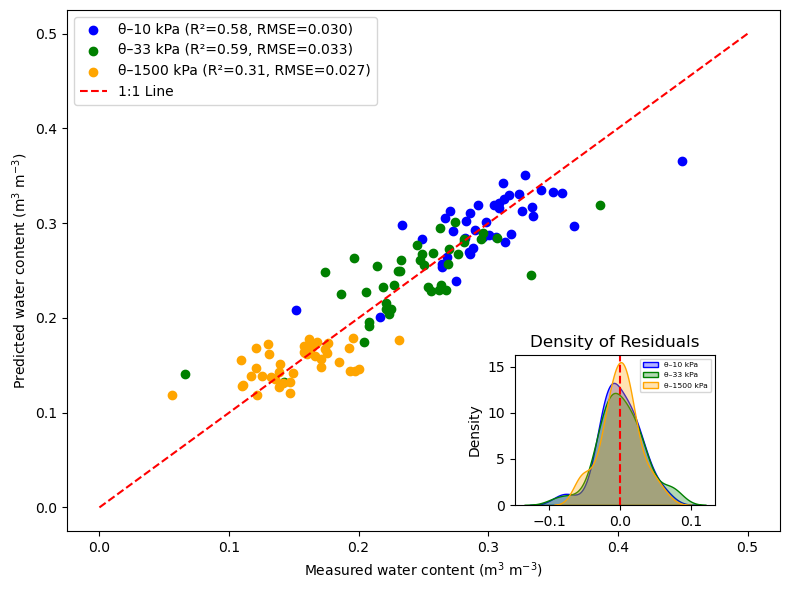

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Read the data
df = pd.read_excel("soil_data.xlsx")
df['SOC'] = df['SOC'] / 10
df['θ-10 kPa'] = df['FC']
df['θ-33 kPa'] = df['FC_33']
df['θ-1500 kPa'] = df['PWP']
df = df.dropna(subset=['SOC', 'sand', 'clay', 'BD', 'WR', 'θ-10 kPa', 'θ-33 kPa', 'θ-1500 kPa'])

# Use the given regression formula to make predictions
predicted_10 = (
    0.2627
    - 0.0032 * df['sand']
    + 0.0014 * df['clay']
    + 0.0166 * df['SOC']
    + 0.1354 * df['BD']
    + 0.0002 * df['WR']
)

predicted_33 = (
    0.1994
    - 0.0035 * df['sand']
    + 0.0034 * df['clay']
    + 0.0177 * df['SOC']
    + 0.1409 * df['BD']
    + 0.0002 * df['WR']
)

predicted_1500 = (
    0.0934
    + 0.0053 * df['clay']
    + 0.0134 * df['SOC']
    - 0.0072 * df['SAR']
)

# Real values
measured_10 = df['θ-10 kPa']
measured_33 = df['θ-33 kPa']
measured_1500 = df['θ-1500 kPa']

# Residul
resid_10 = predicted_10 - measured_10
resid_33 = predicted_33 - measured_33
resid_1500 = predicted_1500 - measured_1500

# R² and RMSE
r2_10 = r2_score(measured_10, predicted_10)
rmse_10 = mean_squared_error(measured_10, predicted_10, squared=False)

r2_33 = r2_score(measured_33, predicted_33)
rmse_33 = mean_squared_error(measured_33, predicted_33, squared=False)

r2_1500 = r2_score(measured_1500, predicted_1500)
rmse_1500 = mean_squared_error(measured_1500, predicted_1500, squared=False)

# plot
plt.figure(figsize=(8, 6))

# main plot：predicted vs measured
plt.scatter(measured_10, predicted_10, color='blue',
            label=f'θ–10 kPa (R²={r2_10:.2f}, RMSE={rmse_10:.3f})')
plt.scatter(measured_33, predicted_33, color='green',
            label=f'θ–33 kPa (R²={r2_33:.2f}, RMSE={rmse_33:.3f})')
plt.scatter(measured_1500, predicted_1500, color='orange',
            label=f'θ–1500 kPa (R²={r2_1500:.2f}, RMSE={rmse_1500:.3f})')
plt.plot([0, 0.5], [0, 0.5], 'r--', label='1:1 Line')

plt.xlabel("Measured water content (m$^3$ m$^{-3}$)")
plt.ylabel("Predicted water content (m$^3$ m$^{-3}$)")
plt.legend()


# Embedding residual density plot
inset_ax = plt.axes([0.65, 0.15, 0.25, 0.25])
sns.kdeplot(resid_10, color='blue', label='θ–10 kPa', fill=True, alpha=0.3)
sns.kdeplot(resid_33, color='green', label='θ–33 kPa', fill=True, alpha=0.3)
sns.kdeplot(resid_1500, color='orange', label='θ–1500 kPa', fill=True, alpha=0.3)
inset_ax.axvline(0, color='red', linestyle='--')
inset_ax.set_title("Density of Residuals")
inset_ax.set_ylabel("Density")
inset_ax.legend(fontsize=5.5)

plt.tight_layout()
plt.savefig("MLR_41.png", dpi=1000)
plt.show()
